In [1]:
from utils.mapping2 import create_dataset, create_embedding_matrix

import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense


In [2]:
path = os.getcwd()
print(path)

r:\Project


In [3]:
feature_src = os.path.join(path, 'features-small')
data_src = os.path.join(path, 'dataset', 'cleaned_data.txt')
features, padded, target_padded, tokenizer, max_len = create_dataset(
    feature_src, data_src)


In [4]:
vocab_size = len(tokenizer.word_index)
embd_vec_size = 100
glove_src = os.path.join(path,'dataset','glove.6B.100d.txt')

In [5]:
embd_matrix = create_embedding_matrix(glove_src, tokenizer.word_index, vocab_size, embd_vec_size)

[ 0.26688    0.39632    0.6169    -0.77451   -0.1039     0.26697
  0.2788     0.30992    0.0054685 -0.085256   0.73602   -0.098432
  0.5479    -0.030305   0.33479    0.14094   -0.0070003  0.32569
  0.22902    0.46557  ]
Embed not found for 206 words


In [13]:
embd_matrix.shape, vocab_size

((2475, 100), 2474)

In [14]:
lstm_units = 100
encoder_input_size = features.shape[2]
time_steps_enc = features.shape[1]

In [15]:
# Encoder

enc_input = Input((None, encoder_input_size), name='enc_input')
enc_lstm = LSTM(lstm_units, return_state=True, name='enc_lstm')
X = enc_input
X = enc_lstm(X)
enc_out, enc_h, enc_c = X
enc_states = [enc_h, enc_c]


In [16]:
# Decoder

dec_input = Input((None,), name='dec_input')
dec_embedding = Embedding(vocab_size+1, embd_vec_size, input_length=max_len,
                          trainable=False, name='dec_embd', mask_zero=True)
dec_lstm = LSTM(lstm_units, return_sequences=True,
                return_state=True, name='dec_lstm')
dec_dense = Dense(vocab_size+1, activation='softmax')
Y = dec_input
Y = dec_embedding(Y)
Y = dec_lstm(Y, initial_state=enc_states)
dec_out, _, _ = Y
Y = dec_dense(dec_out)

In [17]:
# Model

model = Model(inputs=[enc_input, dec_input], outputs=Y)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [18]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_input (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_input (InputLayer)          [(None, None, 4096)] 0                                            
__________________________________________________________________________________________________
dec_embd (Embedding)            (None, None, 100)    247500      dec_input[0][0]                  
__________________________________________________________________________________________________
enc_lstm (LSTM)                 [(None, 100), (None, 1678800     enc_input[0][0]                  
_______________________________________________________________________________________

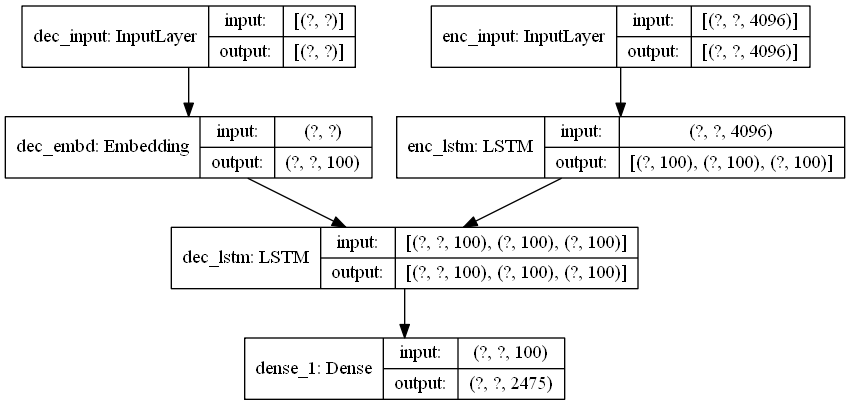

In [19]:
plot_model(model, show_shapes=True)


In [19]:
batch_size = 128
validation_split = 0.1
epochs = 20
validation_batch_size = 128

model.fit(x=[features,padded], y=target_padded, batch_size=batch_size, epochs=epochs,
          validation_split=validation_split, validation_batch_size=validation_batch_size)

Epoch 1/20
30/30 [==============================] - 33s 1s/step - loss: 1.4377 - val_loss: 1.3143
Epoch 2/20
 5/30 [====>.........................] - ETA: 22s - loss: 1.1640

KeyboardInterrupt: 

((4207, 38), (4207, 38))

In [20]:
encoder_model_inf = Model(enc_input, enc_states)

dec_inf_input_h = Input((lstm_units,))
dec_inf_input_c = Input((lstm_units,))
dec_inf_input_states = [dec_inf_input_h, dec_inf_input_c]

dec_inf_out, dec_inf_h, dec_inf_c = dec_lstm(dec_embedding(dec_input),
                                             initial_state=dec_inf_input_states)
dec_inf_states = [dec_inf_h, dec_inf_c]
dec_inf_output = dec_dense(dec_inf_out)

decoder_model_inf = Model(inputs=[dec_input] + dec_inf_input_states,
                          outputs=[dec_inf_output] + dec_inf_states)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, None, 4096)]      0         
_________________________________________________________________
enc_lstm (LSTM)              [(None, 100), (None, 100) 1678800   
Total params: 1,678,800
Trainable params: 1,678,800
Non-trainable params: 0
_________________________________________________________________


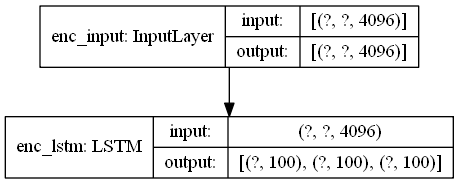

In [21]:
encoder_model_inf.summary()
plot_model(encoder_model_inf, show_shapes=True)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_input (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_embd (Embedding)            (None, None, 100)    247500      dec_input[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
_______________________________________________________________________________________

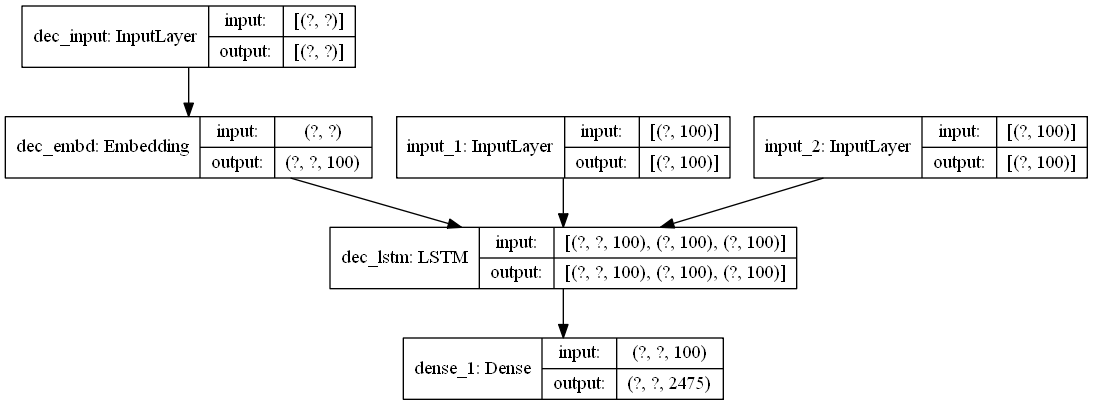

In [22]:
decoder_model_inf.summary()
plot_model(decoder_model_inf, show_shapes=True)